In [1]:

import time
import pandas as pd 
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MaxAbsScaler, maxabs_scale, OrdinalEncoder, LabelEncoder
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE,ADASYN
from sklearn.feature_selection import chi2
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_recall_fscore_support, classification_report,confusion_matrix,mean_squared_error 
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier
import xgboost as xgb
from xgboost import plot_importance
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import plot_tree
import matplotlib.pyplot as plt 
import numpy as np
import matplotlib.image as mpimg
import time
import datetime

In [4]:
df = pd.read_csv("GLC_features_preprocessed.csv", parse_dates=['event_date'])
df['event_description'].fillna(value='', inplace=True)
df.columns

Index(['event_date', 'event_title', 'event_description', 'location_description', 'location_accuracy', 'landslide_category', 'landslide_trigger', 'landslide_size', 'landslide_setting', 'fatality_count', 'injury_count', 'country_name', 'admin_division_name', 'admin_division_population', 'gazeteer_closest_point', 'gazeteer_distance', 'longitude', 'latitude', 'tempmax', 'tempmin', 'temp', 'feelslikemax', 'feelslikemin', 'feelslike', 'dew', 'humidity', 'precip', 'precipcover', 'windgust', 'windspeed', 'winddir', 'pressure', 'cloudcover', 'visibility', 'moonphase', 'conditions', 'stations', 'elevation', 'continent', 'season', 'treecover2000', 'loss', 'gain', 'soil_texture_0', 'soil_texture_10', 'soil_texture_30', 'soil_texture_60', 'soil_texture_100', 'soil_texture_200', 'population_density_2000', 'population_density_2005', 'population_density_2010', 'population_density_2015', 'population_density_2020'], dtype='object')

In [5]:
def preprocessing(df_temp):
    dfs = df_temp.copy(deep = True)
    dfs.drop(['admin_division_population','population_density_2000', 'population_density_2005', 'population_density_2010', 'population_density_2015','tempmax','tempmin',"feelslikemax","feelslikemin"], axis="columns", inplace=True)
    ft = dfs.columns.difference(["landslide_size"])
    category_ft = dfs.select_dtypes(exclude=np.number).columns

    enc = OrdinalEncoder()
    enc.fit(dfs[category_ft])
    dfs[category_ft] = enc.transform(dfs[category_ft])

    labelencoder = LabelEncoder()
    dfs["landslide_size"] = labelencoder.fit_transform(dfs["landslide_size"])

    X = dfs[ft]
    y = dfs["landslide_size"]
    
    X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.8, test_size = 0.2, random_state = 0,stratify = y)
    
    # Scale features
    scaler = MaxAbsScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    # df_train[df_train.select_dtypes(include=np.number).columns] = df_train[df_train.select_dtypes(include=np.number).columns].apply(
    #     lambda x: (x - x.min()) / (x.max()-x.min()))
    # df_test[df_train.select_dtypes(include=np.number).columns] = df_test[df_train.select_dtypes(include=np.number).columns].apply(
    #     lambda x: (x - x.min()) / (x.max()-x.min()))
    # Fill empty values by 0
    return X_train, X_test, y_train, y_test

In [6]:

def train(X_train, y_train, X_test, y_test):
    dt = DecisionTreeClassifier(random_state = 0)
    dt.fit(X_train,y_train) 
    dt_score=dt.score(X_test,y_test)
    dt_y_predict=dt.predict(X_test)
    y_true=y_test
    dt_precision,dt_recall,dt_fscore,none= precision_recall_fscore_support(y_true, dt_y_predict, average='weighted') 
    
    

    dt_train=dt.predict(X_train)
    dt_test=dt.predict(X_test)

    rf = RandomForestClassifier(random_state = 0)
    rf.fit(X_train,y_train) # modelin veri üzerinde öğrenmesi fit fonksiyonuyla yapılıyor
    rf_score=rf.score(X_test,y_test)
    rf_y_predict=rf.predict(X_test)
    y_true=y_test
    rf_precision,rf_recall,rf_fscore,none= precision_recall_fscore_support(y_true, rf_y_predict, average='weighted') 
    
    

    rf_train=rf.predict(X_train)
    rf_test=rf.predict(X_test)

    et = ExtraTreesClassifier(random_state = 0)
    et.fit(X_train,y_train) 
    et_score=et.score(X_test,y_test)
    et_y_predict=et.predict(X_test)
    y_true=y_test
    et_precision,et_recall,et_fscore,none= precision_recall_fscore_support(y_true,et_y_predict, average='weighted') 
    
   
    et_train=et.predict(X_train)
    et_test=et.predict(X_test)

    xg = xgb.XGBClassifier(n_estimators = 10)
    xg.fit(X_train,y_train)
    xg_score=xg.score(X_test,y_test)
    xg_y_predict=xg.predict(X_test)
    y_true=y_test
    xg_precision,xg_recall,xg_fscore,none= precision_recall_fscore_support(y_true, xg_y_predict, average='weighted') 
    
    

    xg_train=xg.predict(X_train)
    xg_test=xg.predict(X_test)

    base_predictions_train = pd.DataFrame( {
    'DecisionTree': dt_train.ravel(),
        'RandomForest': rf_train.ravel(),
     'ExtraTrees': et_train.ravel(),
     'XgBoost': xg_train.ravel(),
    })
    print(base_predictions_train.head(5))

    dt_train=dt_train.reshape(-1, 1)
    et_train=et_train.reshape(-1, 1)
    rf_train=rf_train.reshape(-1, 1)
    xg_train=xg_train.reshape(-1, 1)
    dt_test=dt_test.reshape(-1, 1)
    et_test=et_test.reshape(-1, 1)
    rf_test=rf_test.reshape(-1, 1)
    xg_test=xg_test.reshape(-1, 1)

    x_train = np.concatenate(( dt_train, et_train, rf_train, xg_train), axis=1)
    x_test = np.concatenate(( dt_test, et_test, rf_test, xg_test), axis=1)  
    
    stk = xgb.XGBClassifier().fit(x_train, y_train)
    stk_y_predict=stk.predict(x_test)
    y_true=y_test
    stk_score=accuracy_score(y_true,stk_y_predict)
    stk_precision,stk_recall,stk_fscore,none= precision_recall_fscore_support(y_true, stk_y_predict, average='weighted') 
    

    # plot_tree(stk)
    # plt.show()

    accuracy  = [dt_score, rf_score, et_score, xg_score, stk_score]
    precision = [dt_precision, rf_precision, et_precision, xg_precision, stk_precision]
    recall = [dt_recall, rf_recall, et_recall, xg_recall, stk_recall]
    f1_score = [dt_fscore, rf_fscore, et_fscore, xg_fscore, stk_fscore]
    for i in [accuracy, precision,recall, f1_score]:
        for j in range(0,5):
            i[j] = i[j]*100
    model = ['Decision Tree', 'Random Forest','Extra Tree','XGBoost',"XGBoost Stacking Model"]
    


    fig = plt.figure(figsize=(30, 10))
    plt.plot(model, accuracy) 
    plt.plot(model, precision)
    plt.plot(model, recall)
    plt.plot(model, f1_score)
    plt.xlabel("Models")  # add X-axis label 
    plt.ylabel("Percent")  # add Y-axis label 
    plt.title("Models score chart")  # add title 
    # plt.xticks(rotation=30, ha='right')
    plt.legend(['Accuracy', 'Precision','Recall','Fscore']) 
    plt.show() 



    fig = plt.figure(figsize=(30, 10))
    plt.plot(y_true, dt_y_predict) 
    plt.plot(y_true,rf_y_predict)
    plt.plot(y_true, et_y_predict)
    plt.plot(y_true,xg_y_predict)
    plt.plot(y_true, stk_y_predict)

    plt.xlabel("Models")  # add X-axis label 
    plt.ylabel("Percent")  # add Y-axis label 
    plt.title("Models score chart")  # add title 
    # plt.xticks(rotation=30, ha='right')
    plt.legend(['Decision Tree', 'Random Forest','Extra Tree','XGBoost',"XGBoost Stacking Model"]) 
    plt.show() 





    print(classification_report(y_true,dt_y_predict))
    cm=confusion_matrix(y_true,dt_y_predict)
    f,ax=plt.subplots(figsize=(5,5))
    # f.subplot(2,2,1)
    sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
    plt.xlabel("y_pred")
    plt.ylabel("y_true")
    plt.show()
    print(classification_report(y_true,rf_y_predict))
    cm=confusion_matrix(y_true,rf_y_predict)
    f,ax=plt.subplots(figsize=(5,5))
    # f.subplot(2,2,2)
    sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
    plt.xlabel("y_pred")
    plt.ylabel("y_true")
    plt.show()
    print(classification_report(y_true,et_y_predict))
    cm=confusion_matrix(y_true,et_y_predict)
    f,ax=plt.subplots(figsize=(5,5))
    # plt.subplot(2,2,3)
    sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
    plt.xlabel("y_pred")
    plt.ylabel("y_true")
    plt.show()
    print(classification_report(y_true,xg_y_predict))
    cm=confusion_matrix(y_true,xg_y_predict)
    f,ax=plt.subplots(figsize=(5,5))
    # plt.subplot(2,2,4)
    sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
    plt.xlabel("y_pred")
    plt.ylabel("y_true")
    plt.show()
    cm=confusion_matrix(y_true,stk_y_predict)
    f,ax=plt.subplots(figsize=(5,5))
    # plt.subplot(2,2,5)
    sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
    plt.xlabel("y_pred")
    plt.ylabel("y_true")
    plt.show()
    print(classification_report(y_true,stk_y_predict))






    df_score = pd.DataFrame({'Model': [], 'Accuracy': [], 'Precision': [],'Recall': [],'fscore': []})
    df_score["Model"] = pd.Series(model)
    df_score["Accuracy"] = pd.Series(accuracy)
    df_score["Precision"] = pd.Series(precision)
    df_score["Recall"] = pd.Series(recall)
    df_score["fscore"] = pd.Series(f1_score)
    print(df_score)
    # fig = plt.figure(figsize=(30,20))
    # for i in range(len(numeric_ft)):
    #     ax = plt.subplot(4, 9, i+1)
    #     sns.distplot(df[numeric_ft[i]], kde=True, rug=True, ax=ax)
    
    return dt.feature_importances_, rf.feature_importances_, et.feature_importances_, xg.feature_importances_   

In [7]:
def ft_selection(df_temp, dt_feature, rf_feature, et_feature, xgb_feature):
    
    dfs = df_temp.copy(deep = True)

    ft = dfs.columns.difference(["landslide_size"])
    # calculate the average importance value of each feature
    avg_feature = (dt_feature + rf_feature + et_feature + xgb_feature)/4

    print ("Features sorted by their score:")
    print (sorted(zip(map(lambda x: round(x, 4), avg_feature), ft), reverse=True))

    f_list = sorted(zip(map(lambda x: round(x, 4), avg_feature), ft), reverse=True)
    print(len(f_list))

    # Select the important features from top-importance to bottom-importance until the accumulated importance reaches 0.9 (out of 1)
    Sum = 0
    fs = []
    for i in range(0, len(f_list)):
        Sum = Sum + f_list[i][0]
        fs.append(f_list[i][1])
        if Sum>=0.9:
            break   
    
     
  
    fig = plt.figure(figsize=(30, 10))
    plt.plot(ft, dt_feature, linestyle = 'dashed') 
    plt.plot(ft, rf_feature, linestyle = 'dashed')
    plt.plot(ft, et_feature, linestyle = 'dashed')
    plt.plot(ft, xgb_feature, linestyle = 'dashed')
    plt.plot(ft, avg_feature, linewidth = '10')
    plt.xlabel("Features")  # add X-axis label 
    plt.ylabel("Importance score")  # add Y-axis label 
    plt.title("Immportnace score chart")  # add title 
    plt.xticks(rotation=30, ha='right')
    plt.legend(['Decision Tree Importance Score', 'Random Forest Importance Score','Extra Tree Importance Score','XGBoost Importance Score',"XGBoost Stacking Model"]) 
    plt.show() 
    
    return fs
    # category_ft = dfs.select_dtypes(exclude=np.number).columns
    # enc = OrdinalEncoder()
    # enc.fit(dfs[category_ft])
    # dfs[category_ft] = enc.transform(dfs[category_ft])

    # labelencoder = LabelEncoder()
    # dfs["landslide_size"] = labelencoder.fit_transform(dfs["landslide_size"])
    
    

    # scaler = MaxAbsScaler()
    # X_train = scaler.fit_transform(X_train)
    # X_test = scaler.transform(X_test)

    # print(y_train.value_counts())
    # print(y_test.value_counts())
    # print (fs, len(fs))
    # print(y_train)
    
    # return X_train, y_train, X_test, y_test


   DecisionTree  RandomForest  ExtraTrees  XgBoost
0             2             2           2        2
1             1             1           1        2
2             2             2           2        2
3             4             4           4        4
4             2             2           2        2


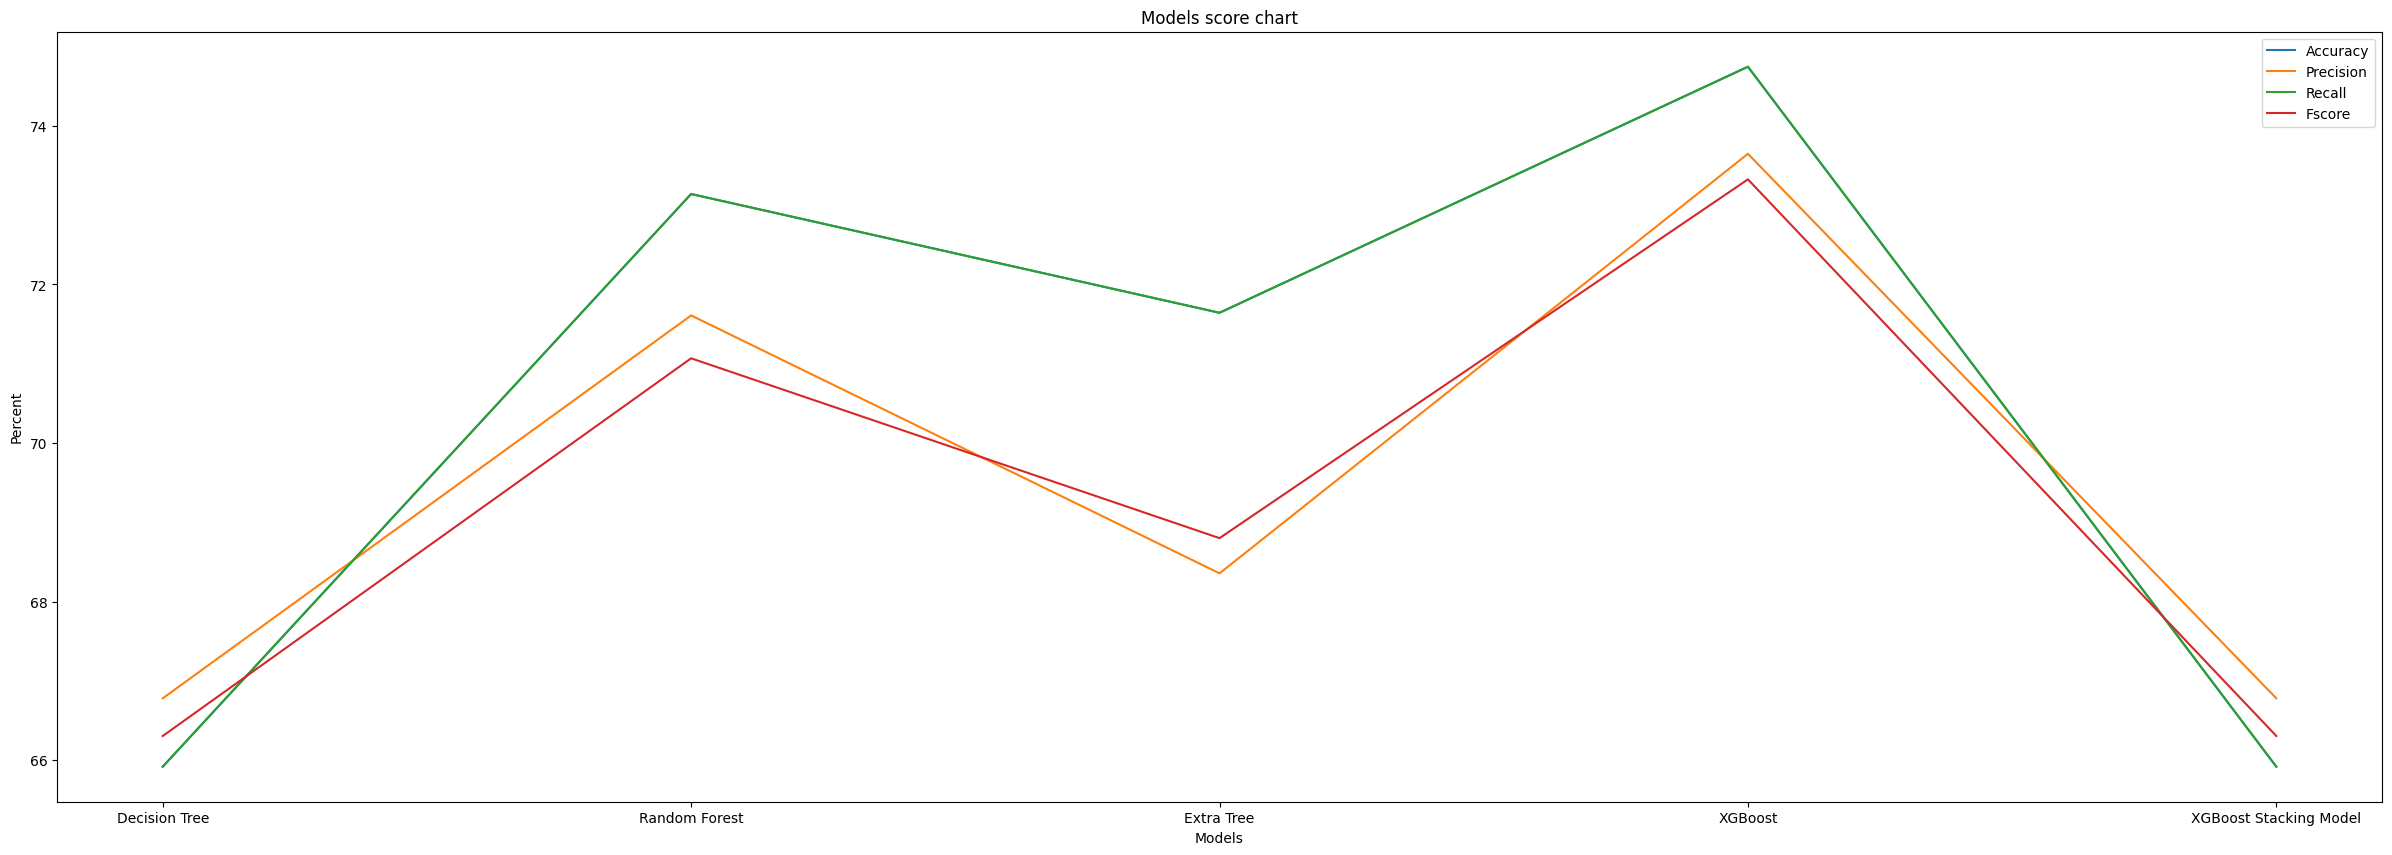

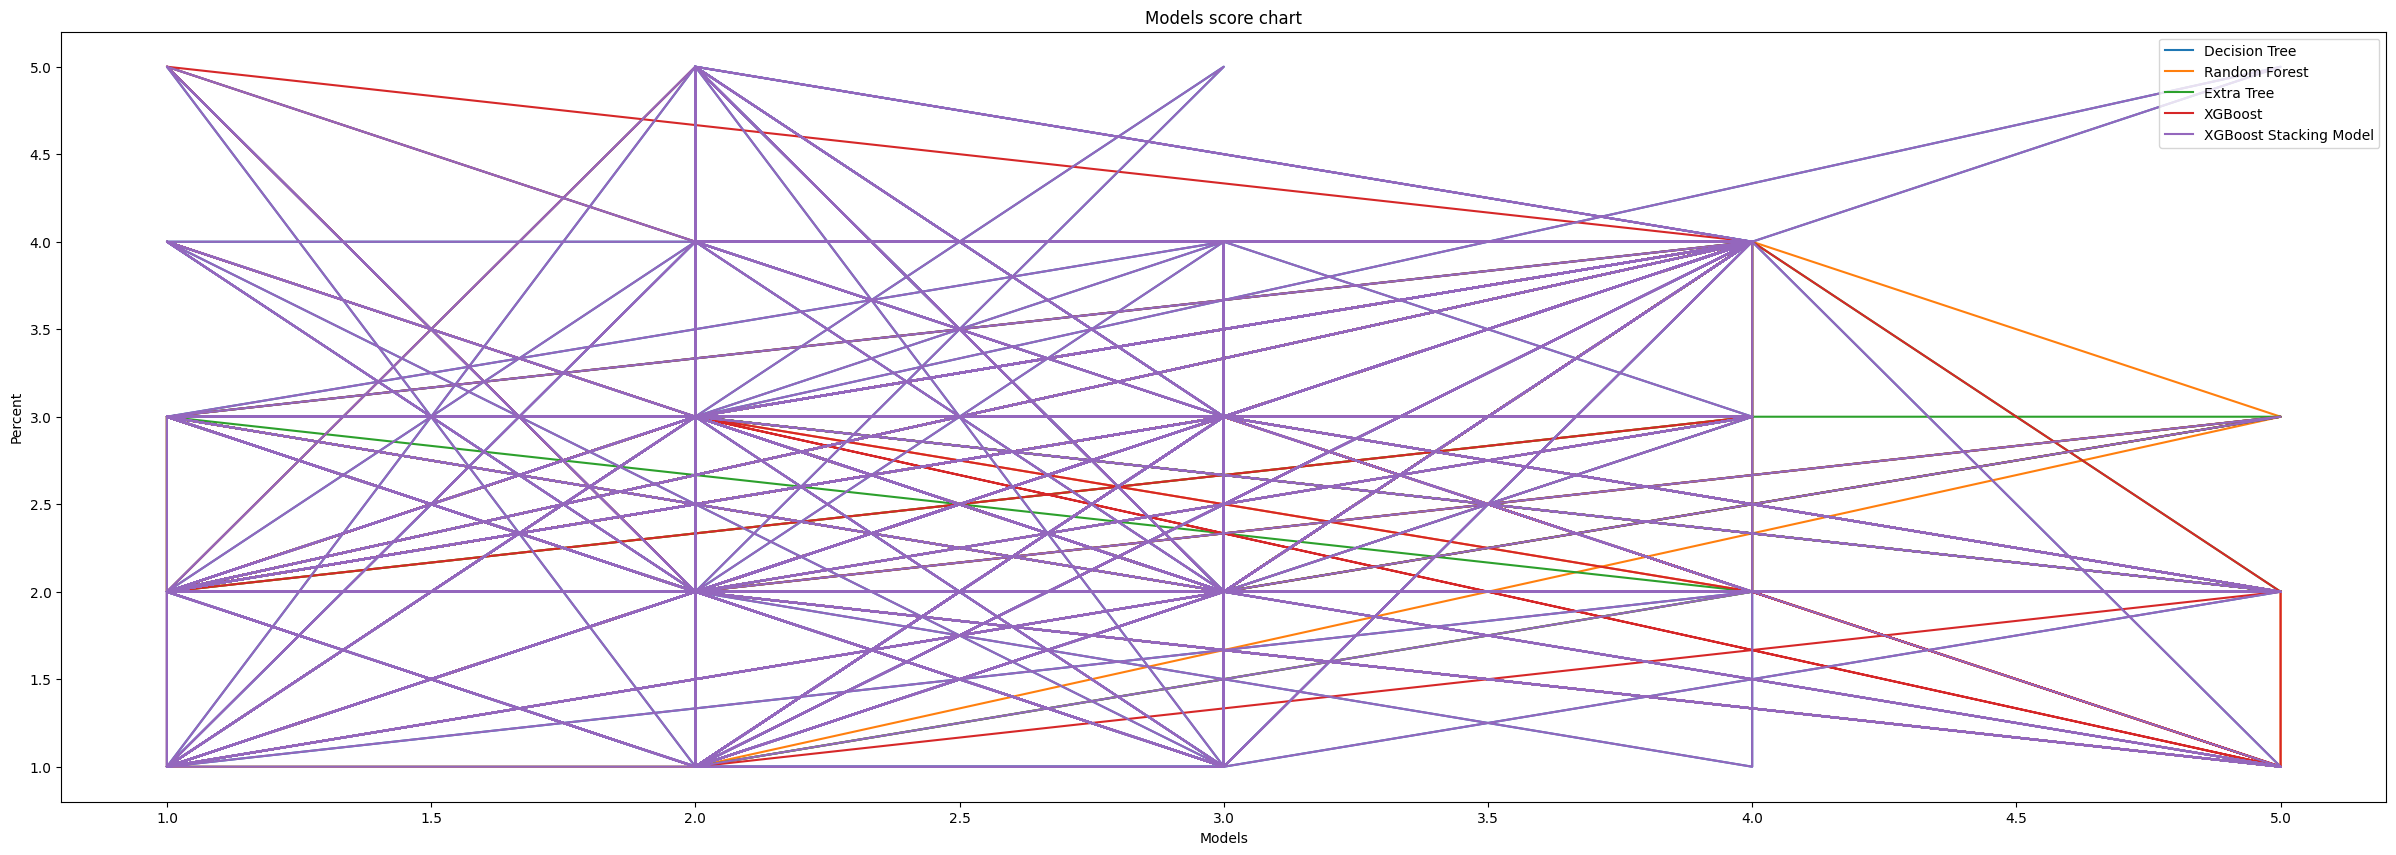

              precision    recall  f1-score   support

           1       0.26      0.31      0.28       118
           2       0.74      0.71      0.73      1074
           3       0.56      0.58      0.57       504
           4       0.88      0.90      0.89       157
           5       0.06      0.06      0.06        16

    accuracy                           0.66      1869
   macro avg       0.50      0.51      0.50      1869
weighted avg       0.67      0.66      0.66      1869



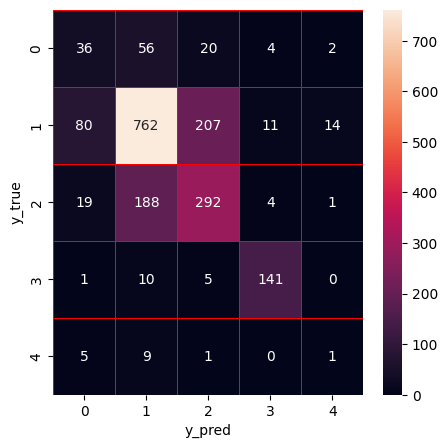

              precision    recall  f1-score   support

           1       0.57      0.14      0.22       118
           2       0.73      0.87      0.79      1074
           3       0.65      0.55      0.60       504
           4       0.99      0.90      0.94       157
           5       0.00      0.00      0.00        16

    accuracy                           0.73      1869
   macro avg       0.59      0.49      0.51      1869
weighted avg       0.72      0.73      0.71      1869



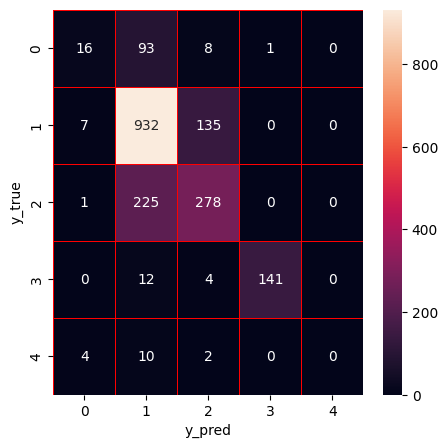

              precision    recall  f1-score   support

           1       0.29      0.02      0.03       118
           2       0.72      0.86      0.78      1074
           3       0.62      0.54      0.58       504
           4       1.00      0.90      0.95       157
           5       0.00      0.00      0.00        16

    accuracy                           0.72      1869
   macro avg       0.53      0.46      0.47      1869
weighted avg       0.68      0.72      0.69      1869



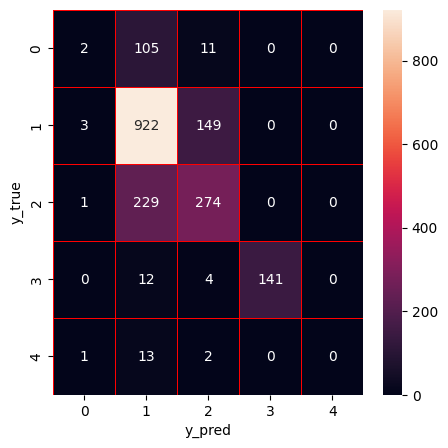

              precision    recall  f1-score   support

           1       0.60      0.18      0.27       118
           2       0.76      0.85      0.80      1074
           3       0.66      0.64      0.65       504
           4       0.99      0.90      0.95       157
           5       0.00      0.00      0.00        16

    accuracy                           0.75      1869
   macro avg       0.60      0.51      0.53      1869
weighted avg       0.74      0.75      0.73      1869



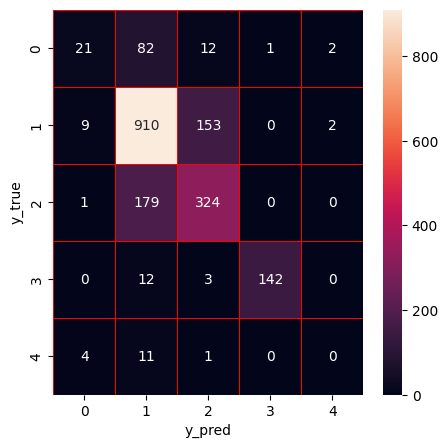

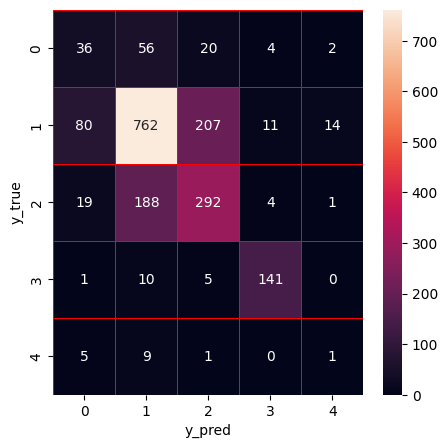

              precision    recall  f1-score   support

           1       0.26      0.31      0.28       118
           2       0.74      0.71      0.73      1074
           3       0.56      0.58      0.57       504
           4       0.88      0.90      0.89       157
           5       0.06      0.06      0.06        16

    accuracy                           0.66      1869
   macro avg       0.50      0.51      0.50      1869
weighted avg       0.67      0.66      0.66      1869

                    Model   Accuracy  Precision     Recall     fscore
0           Decision Tree  65.917603  66.780102  65.917603  66.304931
1           Random Forest  73.140717  71.609343  73.140717  71.068444
2              Extra Tree  71.642590  68.356369  71.642590  68.800466
3                 XGBoost  74.745853  73.647620  74.745853  73.325062
4  XGBoost Stacking Model  65.917603  66.780102  65.917603  66.304931


In [8]:
X_train, X_test, y_train, y_test =  preprocessing(df)
dt_feature, rf_feature, et_feature, xgb_feature = train(X_train, y_train, X_test, y_test)

Features sorted by their score:
[(0.1354, 'event_date'), (0.0773, 'continent'), (0.0691, 'elevation'), (0.0406, 'injury_count'), (0.0401, 'latitude'), (0.0324, 'event_title'), (0.0321, 'landslide_category'), (0.0282, 'feelslikemin'), (0.0272, 'humidity'), (0.0258, 'landslide_setting'), (0.0233, 'longitude'), (0.0217, 'dew'), (0.0201, 'landslide_trigger'), (0.0201, 'event_description'), (0.0201, 'country_name'), (0.0196, 'soil_texture_100'), (0.0196, 'admin_division_name'), (0.0195, 'soil_texture_200'), (0.0194, 'soil_texture_60'), (0.019, 'gain'), (0.0187, 'season'), (0.0184, 'soil_texture_0'), (0.0182, 'population_density_2000'), (0.0181, 'location_description'), (0.0176, 'fatality_count'), (0.0169, 'admin_division_population'), (0.0166, 'feelslikemax'), (0.0158, 'conditions'), (0.0155, 'loss'), (0.0147, 'gazeteer_distance'), (0.0145, 'soil_texture_10'), (0.0141, 'moonphase'), (0.0118, 'population_density_2005'), (0.0117, 'soil_texture_30'), (0.0116, 'population_density_2015'), (0.008

ValueError: x and y must have same first dimension, but have shapes (53,) and (44,)

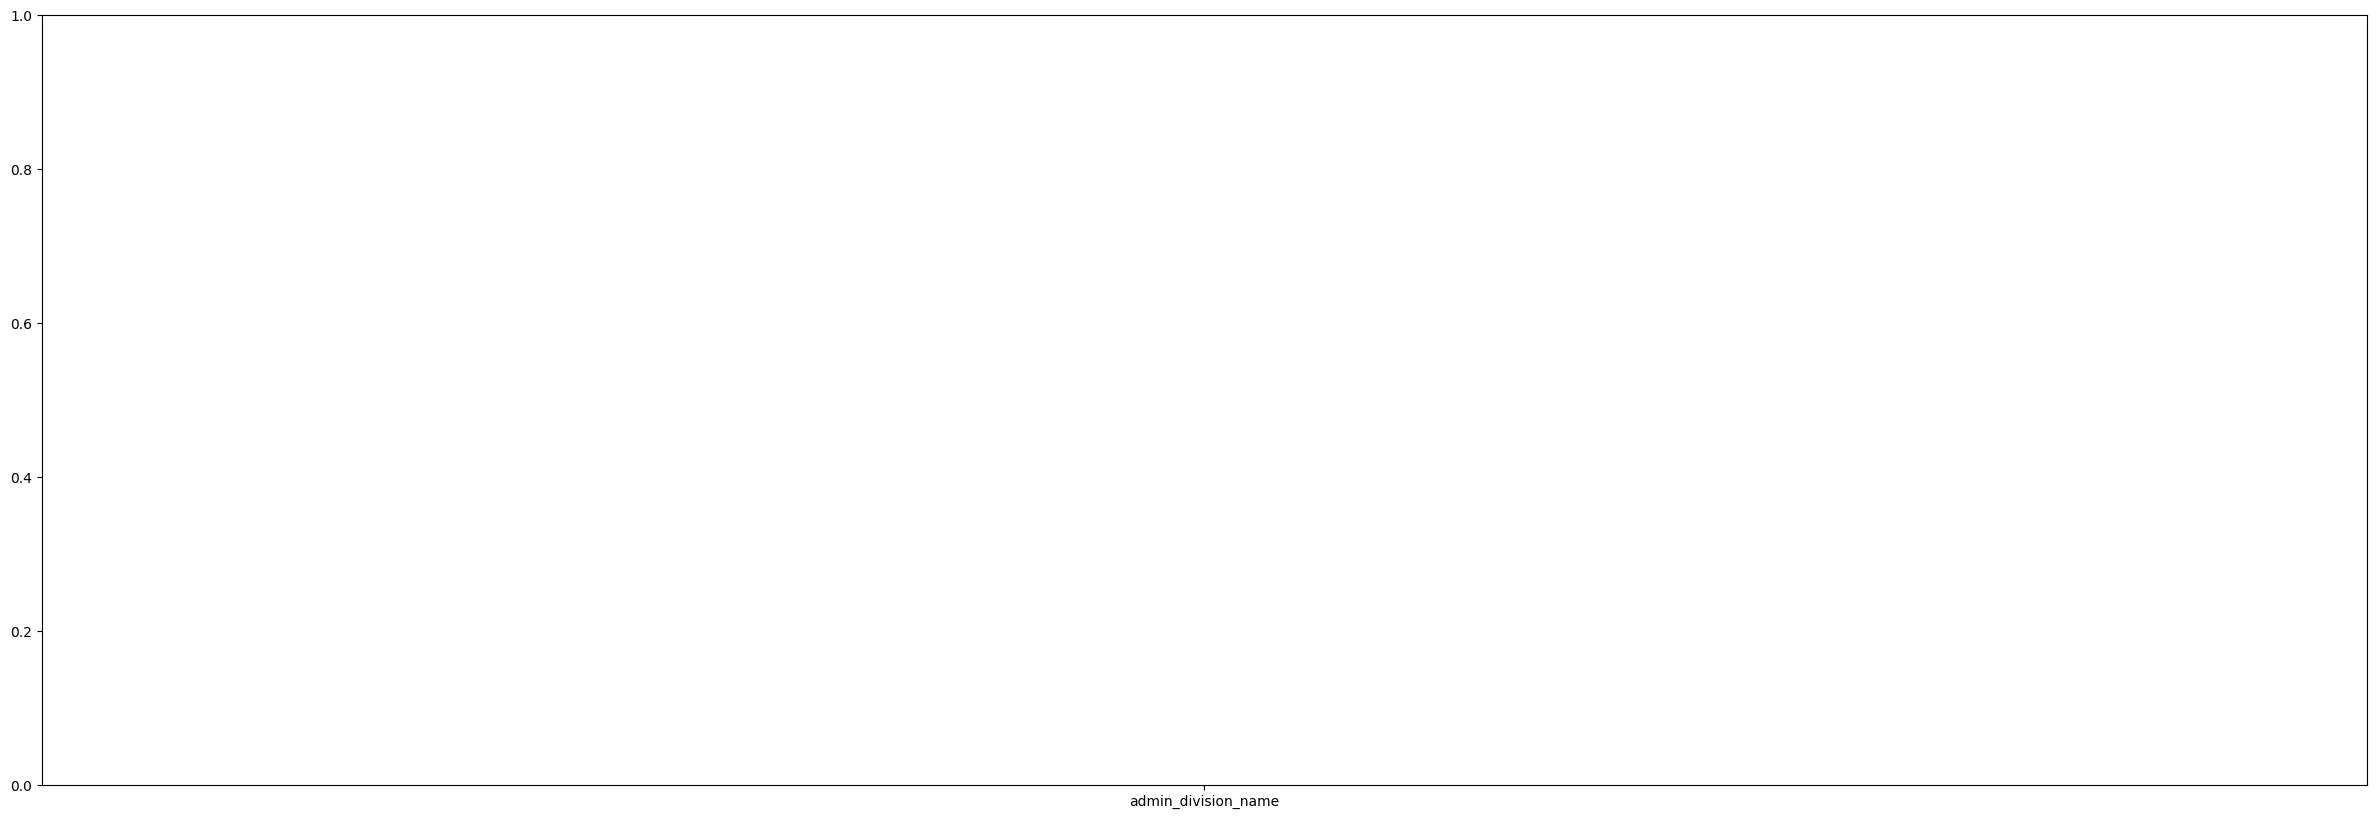

In [9]:
fs = ft_selection(df, dt_feature, rf_feature, et_feature, xgb_feature)

ft = df.columns.difference(["landslide_size"])
category_ft = df.select_dtypes(exclude=np.number).columns

enc = OrdinalEncoder()
enc.fit(df[category_ft])
df[category_ft] = enc.transform(df[category_ft])

labelencoder = LabelEncoder()
df["landslide_size"] = labelencoder.fit_transform(df["landslide_size"])

X_fs = df[fs].values     
y = df["landslide_size"]
    
X_train, X_test, y_train, y_test = train_test_split(X_fs,y, train_size = 0.8, test_size = 0.2, random_state = 0,stratify = y)

scaler = MaxAbsScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
# X_train, X_test, y_train, y_test = ft_selection(df, dt_feature, rf_feature, et_feature, xgb_feature)

train(X_train, y_train, X_test, y_test)